In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import utils.data_processing_bronze_table_feature
import utils.data_processing_silver_table_feature
import utils.data_processing_gold_table_feature

## set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/21 21:47:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## set up config

In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2025-01-01"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01',
 '2025-01-01']

In [5]:
import random

# randomly pick one snapshot date
sample_date = random.choice(dates_str_lst)

## Build Bronze Table

In [6]:
# create bronze datalake (clickstream)
bronze_clickstream_directory = "datamart/bronze/feature/clickstream/"

if not os.path.exists(bronze_clickstream_directory):
    os.makedirs(bronze_clickstream_directory)

In [7]:
# run bronze backfill (clickstream)
for date_str in dates_str_lst:
    utils.data_processing_bronze_table_feature.process_bronze_table_clickstream(date_str, bronze_clickstream_directory, spark)

2023-01-01row count: 8974
saved to: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_01_01.csv
2023-02-01row count: 8974
saved to: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_02_01.csv
2023-03-01row count: 8974
saved to: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_03_01.csv
2023-04-01row count: 8974
saved to: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_04_01.csv
2023-05-01row count: 8974
saved to: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_05_01.csv
2023-06-01row count: 8974
saved to: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_06_01.csv
2023-07-01row count: 8974
saved to: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_07_01.csv
2023-08-01row count: 8974
saved to: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_08_01.csv
2023-09-01row count: 8974
saved to: datamart/bronze/feature/clickstream/bronze_feature_c

In [8]:
# inspect output
utils.data_processing_bronze_table_feature.process_bronze_table_clickstream(sample_date, bronze_clickstream_directory, spark).toPandas()

2023-09-01row count: 8974
saved to: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_09_01.csv


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,221,226,-112,49,226,209,44,123,244,106,...,-102,225,125,74,189,-64,170,57,CUS_0x1037,2023-09-01
1,83,141,184,54,204,76,180,-41,147,238,...,108,199,-33,193,85,144,67,-124,CUS_0x1069,2023-09-01
2,40,96,34,3,101,185,158,105,79,97,...,-49,188,-38,75,121,158,39,49,CUS_0x114a,2023-09-01
3,69,18,169,104,135,67,29,48,173,108,...,153,90,217,224,146,176,-59,153,CUS_0x1184,2023-09-01
4,90,57,145,169,189,167,124,170,-157,246,...,129,-108,-44,289,310,58,508,56,CUS_0x1297,2023-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,38,5,-62,8,149,202,185,300,159,81,...,-40,142,-50,178,57,70,17,36,CUS_0xdf6,2023-09-01
8970,221,52,3,151,187,182,118,256,46,242,...,190,-13,282,25,53,85,80,50,CUS_0xe23,2023-09-01
8971,31,132,-47,83,190,-19,139,125,210,174,...,80,175,100,327,86,24,124,-31,CUS_0xe4e,2023-09-01
8972,168,228,-22,261,69,93,-37,-106,214,228,...,140,22,65,143,-155,61,217,-37,CUS_0xedd,2023-09-01


In [9]:
# create bronze datalake (attributes)
bronze_attributes_directory = "datamart/bronze/feature/attributes/"

if not os.path.exists(bronze_attributes_directory):
    os.makedirs(bronze_attributes_directory)

In [10]:
# run bronze backfill (attributes)
for date_str in dates_str_lst:
    utils.data_processing_bronze_table_feature.process_bronze_table_attributes(date_str, bronze_attributes_directory, spark)

2023-01-01row count: 530
saved to: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_01_01.csv
2023-02-01row count: 501
saved to: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_02_01.csv
2023-03-01row count: 506
saved to: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_03_01.csv
2023-04-01row count: 510
saved to: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_04_01.csv
2023-05-01row count: 521
saved to: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_05_01.csv
2023-06-01row count: 517
saved to: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_06_01.csv
2023-07-01row count: 471
saved to: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_07_01.csv
2023-08-01row count: 481
saved to: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_08_01.csv
2023-09-01row count: 454
saved to: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_09_01.csv
2

In [11]:
# inspect output
utils.data_processing_bronze_table_feature.process_bronze_table_attributes(date_str, bronze_attributes_directory, spark).toPandas()

2025-01-01row count: 526
saved to: datamart/bronze/feature/attributes/bronze_feature_attributes_2025_01_01.csv


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x1009,Arunah,26,063-67-6938,Mechanic,2025-01-01
1,CUS_0x1098,Krudyz,23,466-10-5742,_______,2025-01-01
2,CUS_0x109f,Vellacottj,41,283-32-0255,Teacher,2025-01-01
3,CUS_0x10b6,Gillesw,49,439-76-5364,Journalist,2025-01-01
4,CUS_0x10e2,Sonalio,37,168-78-3262,Media_Manager,2025-01-01
...,...,...,...,...,...,...
521,CUS_0xf15,Frankeld,26,881-11-1453,Developer,2025-01-01
522,CUS_0xf60,Ingrams,17,929-19-3979,Lawyer,2025-01-01
523,CUS_0xf74,Andrew Callusd,19,355-58-6584,Doctor,2025-01-01
524,CUS_0xf95,Alexei Anishchukz,17_,082-42-3634,Entrepreneur,2025-01-01


In [12]:
# create bronze datalake (financials)
bronze_financials_directory = "datamart/bronze/feature/financials/"

if not os.path.exists(bronze_financials_directory):
    os.makedirs(bronze_financials_directory)

In [13]:
# run bronze backfill (financials)
for date_str in dates_str_lst:
    utils.data_processing_bronze_table_feature.process_bronze_table_financials(date_str, bronze_financials_directory, spark)

2023-01-01row count: 530
saved to: datamart/bronze/feature/financials/bronze_feature_financials_2023_01_01.csv
2023-02-01row count: 501
saved to: datamart/bronze/feature/financials/bronze_feature_financials_2023_02_01.csv
2023-03-01row count: 506
saved to: datamart/bronze/feature/financials/bronze_feature_financials_2023_03_01.csv
2023-04-01row count: 510
saved to: datamart/bronze/feature/financials/bronze_feature_financials_2023_04_01.csv
2023-05-01row count: 521
saved to: datamart/bronze/feature/financials/bronze_feature_financials_2023_05_01.csv
2023-06-01row count: 517
saved to: datamart/bronze/feature/financials/bronze_feature_financials_2023_06_01.csv
2023-07-01row count: 471
saved to: datamart/bronze/feature/financials/bronze_feature_financials_2023_07_01.csv
2023-08-01row count: 481
saved to: datamart/bronze/feature/financials/bronze_feature_financials_2023_08_01.csv
2023-09-01row count: 454
saved to: datamart/bronze/feature/financials/bronze_feature_financials_2023_09_01.csv
2

In [14]:
# inspect output
utils.data_processing_bronze_table_feature.process_bronze_table_financials(date_str, bronze_financials_directory, spark).toPandas()

2025-01-01row count: 526
saved to: datamart/bronze/feature/financials/bronze_feature_financials_2025_01_01.csv


,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x1009,52312.68_,4250.390000,6,5,17,4,"Not Specified, Home Equity Loan, Credit-Builde...",5,18,...,_,202.68,40.286997,31 Years and 0 Months,Yes,108.366467,58.66019164829086,High_spent_Medium_value_payments,508.01234122645366,2025-01-01
1,CUS_0x1098,20652.98_,1468.081667,7,5,21,2,"Auto Loan, and Payday Loan",24,10,...,Standard,1859.53,37.441101,18 Years and 11 Months,NM,33.238356,54.60338563277085,Low_spent_Small_value_payments,348.96642479393626,2025-01-01
2,CUS_0x109f,130435.86000000002,10623.655000,4,846,9,2,"Home Equity Loan, and Home Equity Loan",13,1,...,Good,942.71,34.784704,29 Years and 11 Months,NM,188.186133,1070.730679227028,Low_spent_Medium_value_payments,81.1419359951725,2025-01-01
3,CUS_0x10b6,5691341.0,1712.969167,7,3,19,3,"Payday Loan, Credit-Builder Loan, and Debt Con...",6,12,...,Standard,277.93,40.278541,18 Years and 4 Months,No,37.996378,65.372164147804,High_spent_Small_value_payments,327.9283743913377,2025-01-01
4,CUS_0x10e2,43133.85000000001,3432.487500,10,10,31,7,"Personal Loan, Auto Loan, Not Specified, Home ...",43,24,...,Bad,2504.1,27.115861,10 Years and 9 Months,Yes,151.287255,67.89250966068741,High_spent_Large_value_payments,364.0689853638198,2025-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,CUS_0xf15,45652.17,3888.347500,8,6,13,7,"Mortgage Loan, Payday Loan, Debt Consolidation...",10,10,...,_,28.54,26.846632,10 Years and 11 Months,Yes,160.473304,154.47086437898875,Low_spent_Medium_value_payments,353.8905820472088,2025-01-01
522,CUS_0xf60,34413.76,2916.813333,6,5,8,5,"Home Equity Loan, Home Equity Loan, Home Equit...",23,20,...,_,113.06,24.508003,6 Years and 4 Months,Yes,74.328709,330.7631176311532,Low_spent_Small_value_payments,176.5895062534961,2025-01-01
523,CUS_0xf74,17111.35,1367.645556,10,6,3868,7,"Personal Loan, Mortgage Loan, Home Equity Loan...",55,25,...,Bad,1763.48,25.724679,19 Years and 0 Months,Yes,95.734001,55.60022588346901,Low_spent_Medium_value_payments,264.66063434363843,2025-01-01
524,CUS_0xf95,15604.56,1389.380000,9,5,25,3,"Debt Consolidation Loan, Home Equity Loan, and...",27,23,...,Bad,2686.18,35.184082,19 Years and 10 Months,Yes,37.912350,92.1139885286824,Low_spent_Small_value_payments,298.9116613286117,2025-01-01


## Build Silver Table

In [15]:
# create silver datalake (clickstream)
silver_clickstream_directory = "datamart/silver/feature/clickstream/"

if not os.path.exists(silver_clickstream_directory):
    os.makedirs(silver_clickstream_directory)

In [16]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table_feature.process_silver_table_clickstream(date_str, bronze_clickstream_directory, silver_clickstream_directory, spark)

loaded from: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_01_01.csv row count: 8974
saved to: datamart/silver/feature/clickstream/silver_feature_clickstream_2023_01_01.parquet
loaded from: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_02_01.csv row count: 8974
saved to: datamart/silver/feature/clickstream/silver_feature_clickstream_2023_02_01.parquet
loaded from: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_03_01.csv row count: 8974
saved to: datamart/silver/feature/clickstream/silver_feature_clickstream_2023_03_01.parquet
loaded from: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_04_01.csv row count: 8974
saved to: datamart/silver/feature/clickstream/silver_feature_clickstream_2023_04_01.parquet
loaded from: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_05_01.csv row count: 8974
saved to: datamart/silver/feature/clickstream/silver_feature_clickstream_2023_05_01.parquet
loade

In [17]:
utils.data_processing_silver_table_feature.process_silver_table_clickstream(sample_date, bronze_clickstream_directory, silver_clickstream_directory, spark).toPandas()

loaded from: datamart/bronze/feature/clickstream/bronze_feature_clickstream_2023_09_01.csv row count: 8974
saved to: datamart/silver/feature/clickstream/silver_feature_clickstream_2023_09_01.parquet


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date,fe_1_5_mean
0,221.0,226.0,-112.0,49.0,226.0,209.0,44.0,123.0,244.0,106.0,...,225.0,125.0,74.0,189.0,-64.0,170.0,57.0,CUS_0x1037,2023-09-01,122.000000
1,83.0,141.0,184.0,54.0,204.0,76.0,180.0,-41.0,147.0,238.0,...,199.0,-33.0,193.0,85.0,144.0,67.0,-124.0,CUS_0x1069,2023-09-01,133.199997
2,40.0,96.0,34.0,3.0,101.0,185.0,158.0,105.0,79.0,97.0,...,188.0,-38.0,75.0,121.0,158.0,39.0,49.0,CUS_0x114a,2023-09-01,54.799999
3,69.0,18.0,169.0,104.0,135.0,67.0,29.0,48.0,173.0,108.0,...,90.0,217.0,224.0,146.0,176.0,-59.0,153.0,CUS_0x1184,2023-09-01,99.000000
4,90.0,57.0,145.0,169.0,189.0,167.0,124.0,170.0,-157.0,246.0,...,-108.0,-44.0,289.0,310.0,58.0,508.0,56.0,CUS_0x1297,2023-09-01,130.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,38.0,5.0,-62.0,8.0,149.0,202.0,185.0,300.0,159.0,81.0,...,142.0,-50.0,178.0,57.0,70.0,17.0,36.0,CUS_0xdf6,2023-09-01,27.600000
8970,221.0,52.0,3.0,151.0,187.0,182.0,118.0,256.0,46.0,242.0,...,-13.0,282.0,25.0,53.0,85.0,80.0,50.0,CUS_0xe23,2023-09-01,122.800003
8971,31.0,132.0,-47.0,83.0,190.0,-19.0,139.0,125.0,210.0,174.0,...,175.0,100.0,327.0,86.0,24.0,124.0,-31.0,CUS_0xe4e,2023-09-01,77.800003
8972,168.0,228.0,-22.0,261.0,69.0,93.0,-37.0,-106.0,214.0,228.0,...,22.0,65.0,143.0,-155.0,61.0,217.0,-37.0,CUS_0xedd,2023-09-01,140.800003


In [18]:
# create silver datalake (attributes)
silver_attributes_directory = "datamart/silver/feature/attributes/"

if not os.path.exists(silver_attributes_directory):
    os.makedirs(silver_attributes_directory)

In [19]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table_feature.process_silver_table_attributes(date_str, bronze_attributes_directory, silver_attributes_directory, spark)

loaded from: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_01_01.csv row count: 530
saved to: datamart/silver/feature/attributes/silver_features_attributes_2023_01_01.parquet
loaded from: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_02_01.csv row count: 501
saved to: datamart/silver/feature/attributes/silver_features_attributes_2023_02_01.parquet
loaded from: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_03_01.csv row count: 506
saved to: datamart/silver/feature/attributes/silver_features_attributes_2023_03_01.parquet
loaded from: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_04_01.csv row count: 510
saved to: datamart/silver/feature/attributes/silver_features_attributes_2023_04_01.parquet
loaded from: datamart/bronze/feature/attributes/bronze_feature_attributes_2023_05_01.csv row count: 521
saved to: datamart/silver/feature/attributes/silver_features_attributes_2023_05_01.parquet
loaded from: datamart/bro

In [20]:
utils.data_processing_silver_table_feature.process_silver_table_attributes(date_str, bronze_attributes_directory, silver_attributes_directory, spark).toPandas()

loaded from: datamart/bronze/feature/attributes/bronze_feature_attributes_2025_01_01.csv row count: 526
saved to: datamart/silver/feature/attributes/silver_features_attributes_2025_01_01.parquet


,Customer_ID,Name,SSN,Occupation,snapshot_date,Age_num,Age_missing
0,CUS_0x1009,Arunah,063-67-6938,Mechanic,2025-01-01,26,0
1,CUS_0x1098,Krudyz,466-10-5742,Unknown,2025-01-01,23,0
2,CUS_0x109f,Vellacottj,283-32-0255,Teacher,2025-01-01,41,0
3,CUS_0x10b6,Gillesw,439-76-5364,Journalist,2025-01-01,49,0
4,CUS_0x10e2,Sonalio,168-78-3262,Media_Manager,2025-01-01,37,0
...,...,...,...,...,...,...,...
521,CUS_0xf15,Frankeld,881-11-1453,Developer,2025-01-01,26,0
522,CUS_0xf60,Ingrams,929-19-3979,Lawyer,2025-01-01,17,0
523,CUS_0xf74,Andrew Callusd,355-58-6584,Doctor,2025-01-01,19,0
524,CUS_0xf95,Alexei Anishchukz,082-42-3634,Entrepreneur,2025-01-01,150,1


In [21]:
# create silver datalake (financials)
silver_financials_directory = "datamart/silver/feature/financials/"

if not os.path.exists(silver_financials_directory):
    os.makedirs(silver_financials_directory)

In [22]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table_feature.process_silver_table_financials(date_str, bronze_financials_directory, silver_financials_directory, spark)

loaded from: datamart/bronze/feature/financials/bronze_feature_financials_2023_01_01.csv row count: 530
saved to: datamart/silver/feature/financials/silver_feature_financials_2023_01_01.parquet
loaded from: datamart/bronze/feature/financials/bronze_feature_financials_2023_02_01.csv row count: 501
saved to: datamart/silver/feature/financials/silver_feature_financials_2023_02_01.parquet
loaded from: datamart/bronze/feature/financials/bronze_feature_financials_2023_03_01.csv row count: 506
saved to: datamart/silver/feature/financials/silver_feature_financials_2023_03_01.parquet
loaded from: datamart/bronze/feature/financials/bronze_feature_financials_2023_04_01.csv row count: 510
saved to: datamart/silver/feature/financials/silver_feature_financials_2023_04_01.parquet
loaded from: datamart/bronze/feature/financials/bronze_feature_financials_2023_05_01.csv row count: 521
saved to: datamart/silver/feature/financials/silver_feature_financials_2023_05_01.parquet
loaded from: datamart/bronze/f

In [23]:
utils.data_processing_silver_table_feature.process_silver_table_financials(date_str, bronze_financials_directory, silver_financials_directory, spark).toPandas()

loaded from: datamart/bronze/feature/financials/bronze_feature_financials_2025_01_01.csv row count: 526
saved to: datamart/silver/feature/financials/silver_feature_financials_2025_01_01.parquet


,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Auto_Loan_count,Credit_Builder_Loan_count,Debt_Consolidation_Loan_count,Home_Equity_Loan_count,Mortgage_Loan_count,Not_Specified_count,Payday_Loan_count,Personal_Loan_count,Student_Loan_count,Unknown_count
0,CUS_0x1009,5.231268e+04,4250.390137,6,5,17,4.0,5,18.0,9.730000,...,0,1,0,1,0,1,1,0,0,0
1,CUS_0x1098,2.065298e+04,1468.081665,7,5,21,2.0,24,10.0,8.580000,...,1,0,0,0,0,0,1,0,0,0
2,CUS_0x109f,1.304359e+05,10623.655273,4,846,9,2.0,13,1.0,12.850000,...,0,0,0,2,0,0,0,0,0,0
3,CUS_0x10b6,5.691341e+06,1712.969116,7,3,19,3.0,6,12.0,1.230000,...,0,1,1,0,0,0,1,0,0,0
4,CUS_0x10e2,4.313385e+04,3432.487549,10,10,31,7.0,43,24.0,6.410000,...,1,2,0,2,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,CUS_0xf15,4.565217e+04,3888.347412,8,6,13,7.0,10,10.0,17.940001,...,1,1,1,0,1,0,2,0,1,0
522,CUS_0xf60,3.441376e+04,2916.813232,6,5,8,5.0,23,20.0,7.660000,...,0,0,0,3,1,1,0,0,0,0
523,CUS_0xf74,1.711135e+04,1367.645508,10,6,3868,7.0,55,25.0,12.920000,...,0,0,1,2,1,1,1,1,0,0
524,CUS_0xf95,1.560456e+04,1389.380005,9,5,25,3.0,27,23.0,8.080000,...,0,0,1,1,0,1,0,0,0,0


## EDA on features

In [24]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt

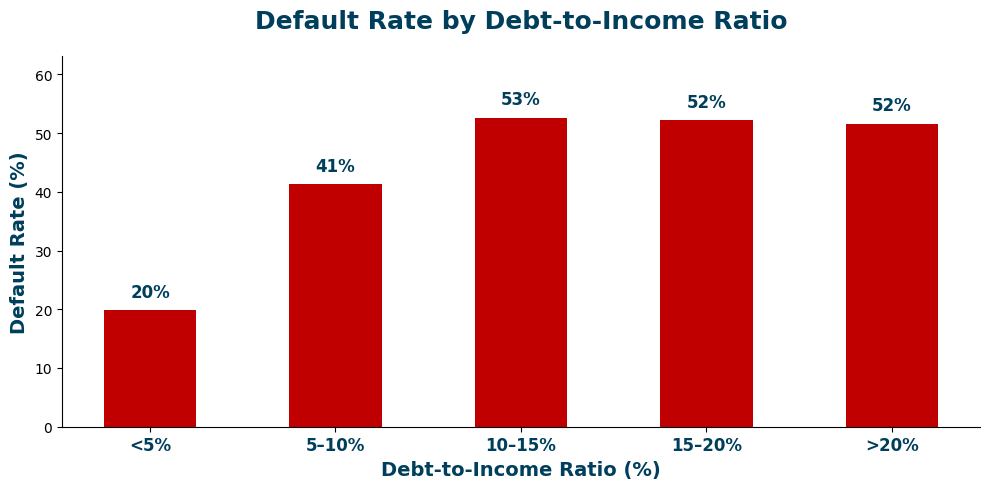

In [25]:
# Load & concatenate all silver financial Parquets via Spark 
fin_paths = sorted(glob.glob("datamart/silver/feature/financials/*.parquet"))
fin_sdf = spark.read.parquet(*fin_paths)
fin_df  = fin_sdf.toPandas()

# Load & concatenate all gold label Parquets via Spark 
lab_paths = sorted(glob.glob("datamart/gold/label_store/*.parquet"))
lab_sdf   = spark.read.parquet(*lab_paths).select("Customer_ID","label")
lab_df    = lab_sdf.toPandas().drop_duplicates(subset="Customer_ID")

# Merge on Customer_ID
df = (
    fin_df
    .merge(lab_df, on="Customer_ID", how="inner")
    .rename(columns={"label":"default"})
)

# Compute Debt-to-Income Ratio 
df = df[df["Annual_Income"] > 0].copy()
df["DTI"] = df["Outstanding_Debt"] / df["Annual_Income"]

bins   = [0,0.05,0.10,0.15,0.20,float("inf")]
labels = ["<5%","5–10%","10–15%","15–20%",">20%"]
df["DTI_Bin"] = pd.cut(df["DTI"], bins=bins, labels=labels, include_lowest=True)

rates = df.groupby("DTI_Bin", observed=False)["default"].mean() * 100
rates = rates.reindex(labels)

# Plot
def plot_default_by_bins_red(rates, labels, title):
    navy, red = "#003f5c","#C00000"
    fig,ax = plt.subplots(figsize=(10,5),dpi=100)
    x = range(len(labels))
    ax.bar(x, rates.values, color=red, width=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontweight='bold', color=navy, fontsize=12)
    ax.set_xlabel('Debt-to-Income Ratio (%)',
                  fontweight='bold', color=navy, fontsize=14)
    ax.set_ylabel('Default Rate (%)',
                  fontweight='bold', color=navy, fontsize=14)
    ax.set_ylim(0, rates.max()*1.2)
    ax.set_title(title,
                 fontweight='bold', color=navy, fontsize=18, pad=20)
    for xi,pct in zip(x,rates.values):
        ax.text(xi, pct+rates.max()*0.03, f'{pct:.0f}%',
                ha='center', va='bottom',
                fontweight='bold', color=navy, fontsize=12)
    plt.tight_layout()
    plt.show()

plot_default_by_bins_red(rates, labels, 'Default Rate by Debt-to-Income Ratio')

In [26]:
from pyspark.sql.types import StringType, DoubleType

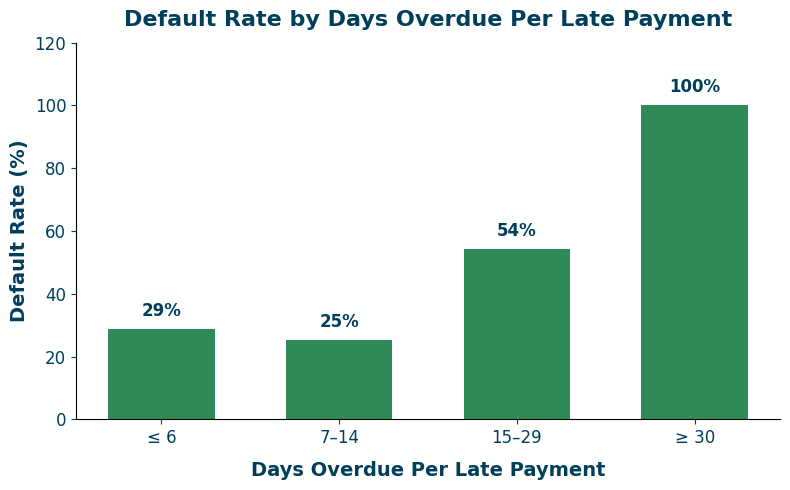

In [27]:
# Load & merge feature + label (as Spark DataFrames)
fin_paths = sorted(glob.glob("datamart/silver/feature/financials/*.parquet"))
lab_paths = sorted(glob.glob("datamart/gold/label_store/*.parquet"))

fin_sdf = spark.read.parquet(*fin_paths)
lab_sdf = (spark.read.parquet(*lab_paths)
                .select("Customer_ID", "label"))

# join on Customer_ID, keep only records with a label
sdf = (fin_sdf.join(lab_sdf, on="Customer_ID", how="inner")
             .withColumnRenamed("label", "default"))

# Compute Avg_Delay 
sdf = sdf.withColumn(
    "Avg_Delay",
    F.when(F.col("Num_of_Delayed_Payment") > 0,
           F.col("Delay_from_due_date") / F.col("Num_of_Delayed_Payment")
    )
    .otherwise(F.lit(0.0))
)

# Bin into 4 categories 
sdf = sdf.withColumn(
    "Delay_Bin",
    F.when(F.col("Avg_Delay") < 7,           "≤ 6")
     .when((F.col("Avg_Delay") >= 7) & (F.col("Avg_Delay") < 15), "7–14")
     .when((F.col("Avg_Delay") >= 15)& (F.col("Avg_Delay") < 30), "15–29")
     .otherwise("≥ 30")
)

# Compute default‐rate per bin 
rates_sdf = (
    sdf.groupBy("Delay_Bin")
       .agg(F.mean("default").alias("default_rate"))
)

# Pandas for plot
order = ["≤ 6", "7–14", "15–29", "≥ 30"]
rates_pdf = (
    rates_sdf.toPandas()
             .set_index("Delay_Bin")
             .reindex(order)
             .reset_index()
)
rates_pdf["default_rate_pct"] = rates_pdf["default_rate"] * 100

# Plot
navy = "#003f5c"
color = "#2E8B57"

fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
ax.bar(rates_pdf["Delay_Bin"], rates_pdf["default_rate_pct"],
       color=color, width=0.6)

ax.set_title("Default Rate by Days Overdue Per Late Payment",
             fontsize=16, fontweight="bold", color=navy, pad=12)
ax.set_xlabel("Days Overdue Per Late Payment",
              fontsize=14, fontweight="bold", color=navy, labelpad=10)
ax.set_ylabel("Default Rate (%)",
              fontsize=14, fontweight="bold", color=navy)
ax.set_ylim(0, rates_pdf["default_rate_pct"].max() * 1.2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", labelsize=12, colors=navy)
ax.tick_params(axis="y", labelsize=12, colors=navy)

for i, val in enumerate(rates_pdf["default_rate_pct"]):
    ax.text(i, val + rates_pdf["default_rate_pct"].max() * 0.03,
            f"{val:.0f}%", ha="center", va="bottom",
            fontsize=12, fontweight="bold", color=navy)

plt.tight_layout()
plt.show()

In [28]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

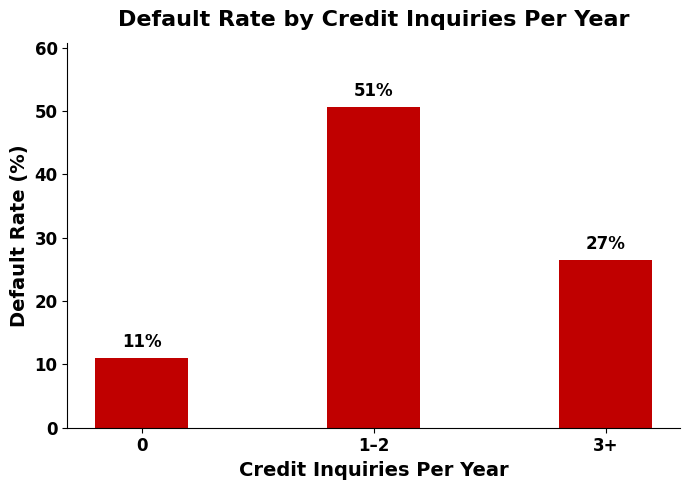

In [29]:
# Load & concatenate all silver financial Parquets 
fin_paths = sorted(glob.glob("datamart/silver/feature/financials/*.parquet"))
fin_sdf   = spark.read.parquet(*fin_paths)

# Load & concatenate all gold label Parquets 
lab_paths = sorted(glob.glob("datamart/gold/label_store/*.parquet"))
lab_sdf   = (
    spark.read.parquet(*lab_paths)
         .select("Customer_ID", "label")
)

#Join feature + label
sdf = (
    fin_sdf.join(lab_sdf, on="Customer_ID", how="inner")
           .withColumnRenamed("label", "default")
)

# Compute Inquiry_Rate
sdf = (
    sdf
    # cast both sides to double
    .withColumn("Num_Credit_Inquiries", F.col("Num_Credit_Inquiries").cast("double"))
    .withColumn("Credit_History_Age_num", F.col("Credit_History_Age_num").cast("double"))
    # do the division, but if age==0 produce null → fillna(0)
    .withColumn(
        "Inquiry_Rate",
        (F.col("Num_Credit_Inquiries") / 
         F.when(F.col("Credit_History_Age_num") == 0, None)
          .otherwise(F.col("Credit_History_Age_num"))
        )
    )
    .na.fill({"Inquiry_Rate": 0.0})
)

# Bucket into exactly 3 groups: "0", "1–2", "3+" 
sdf = sdf.withColumn(
    "Inquiry_Bin",
    F.when(F.col("Inquiry_Rate") == 0,         F.lit("0"))
     .when((F.col("Inquiry_Rate") >= 1) & 
           (F.col("Inquiry_Rate") <= 2),      F.lit("1–2"))
     .otherwise(F.lit("3+"))
)

# Compute default‐rate per bin (as percent)
rates_sdf = (
    sdf.groupBy("Inquiry_Bin")
       .agg((F.mean("default") * 100).alias("default_rate_pct"))
)

# Pandas 
order = ["0", "1–2", "3+"]
rates_pdf = (
    rates_sdf.toPandas()
             .set_index("Inquiry_Bin")
             .reindex(order)            
             .reset_index()
)

#Plot 
plt.rc('font', family='sans-serif')
plt.rc('axes', titlesize=16, titleweight='bold', 
       labelsize=14, labelweight='bold')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

fig, ax = plt.subplots(figsize=(7,5), dpi=100)

bar_color = '#C00000' 
bars = ax.bar(
    rates_pdf["Inquiry_Bin"],
    rates_pdf["default_rate_pct"],
    color=bar_color,
    width=0.4
)


ax.set_title('Default Rate by Credit Inquiries Per Year', pad=12)
ax.set_xlabel('Credit Inquiries Per Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Default Rate (%)', fontsize=14, fontweight='bold')


ax.set_ylim(0, rates_pdf["default_rate_pct"].max() * 1.2)


for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontweight('bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + rates_pdf["default_rate_pct"].max() * 0.02,
        f'{h:.0f}%',
        ha='center', va='bottom',
        fontsize=12, fontweight='bold'
    )

plt.tight_layout()
plt.show()

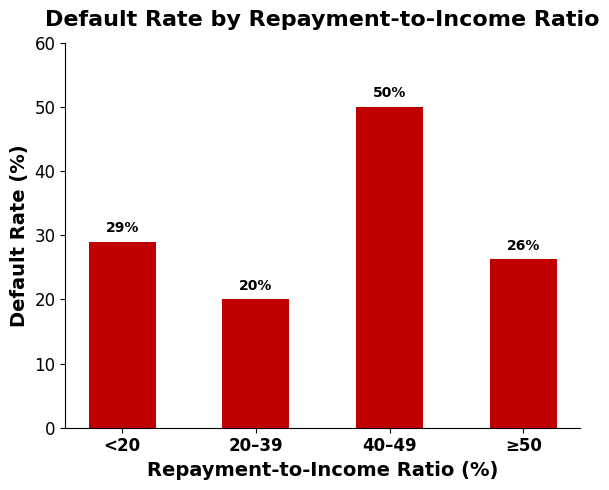

In [31]:
import glob
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F

spark = SparkSession.builder.getOrCreate()

# load silver financials
fin_paths = sorted(glob.glob("datamart/silver/feature/financials/*.parquet"))
fin_sdf   = spark.read.parquet(*fin_paths)

# load gold labels
lab_paths = sorted(glob.glob("datamart/gold/label_store/*.parquet"))
lab_sdf   = (
    spark.read.parquet(*lab_paths)
         .select("Customer_ID", "label")
         .withColumnRenamed("label", "default")
)

# join and compute EMI burden
sdf = (
    fin_sdf.join(lab_sdf, on="Customer_ID", how="inner")
           .withColumn("Total_EMI_per_month",   F.col("Total_EMI_per_month").cast(DoubleType()))
           .withColumn("Monthly_Inhand_Salary", F.col("Monthly_Inhand_Salary").cast(DoubleType()))
           .withColumn(
               "EMI_Burden",
               F.col("Total_EMI_per_month") /
               F.when(F.col("Monthly_Inhand_Salary")==0, None)
                .otherwise(F.col("Monthly_Inhand_Salary"))
           )
           .na.fill({"EMI_Burden": 0.0})
)

# bin and compute default rate
sdf = sdf.withColumn(
    "EMI_Bin",
    F.when( F.col("EMI_Burden") < 0.20,         F.lit("<20")   )
     .when((F.col("EMI_Burden") >= 0.20) &
           (F.col("EMI_Burden") < 0.40),      F.lit("20–39") )
     .when((F.col("EMI_Burden") >= 0.40) &
           (F.col("EMI_Burden") < 0.50),      F.lit("40–49") )
     .otherwise(                              F.lit("≥50")   )
)

rates_sdf = sdf.groupBy("EMI_Bin") \
               .agg((F.mean("default") * 100).alias("default_rate_pct"))

order = ["<20","20–39","40–49","≥50"]
rates_pdf = rates_sdf.toPandas().set_index("EMI_Bin") \
                   .reindex(order).reset_index()

# plot
fig, ax = plt.subplots(figsize=(6,5), dpi=100)
x = np.arange(len(order))
bars = ax.bar(x, rates_pdf["default_rate_pct"], color="#C00000", width=0.5)

ax.set_title("Default Rate by Repayment-to-Income Ratio", pad=12, fontweight="bold")
ax.set_xlabel("Repayment-to-Income Ratio (%)", fontweight="bold")
ax.set_ylabel("Default Rate (%)", fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(order, fontweight="bold")
ax.set_ylim(0, rates_pdf["default_rate_pct"].max() * 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for xi, bar in zip(x, bars):
    h = bar.get_height()
    ax.text(xi, h + rates_pdf["default_rate_pct"].max()*0.02,
            f"{h:.0f}%", ha="center", va="bottom", fontweight="bold")

plt.tight_layout()
plt.show()

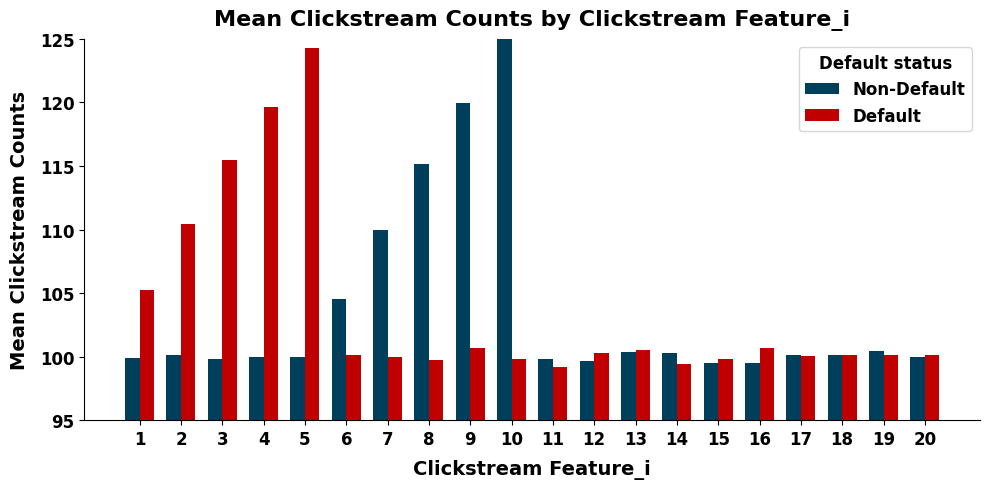

In [32]:
# Load & combine Silver clickstream Parquets 
click_paths = sorted(glob.glob("datamart/silver/feature/clickstream/*.parquet"))
click_sdf   = spark.read.parquet(*click_paths)

# Load & combine Gold labels
label_paths = sorted(glob.glob("datamart/gold/label_store/*.parquet"))
label_sdf   = (
    spark.read.parquet(*label_paths)
         .select("Customer_ID", "label")
         .withColumnRenamed("label", "default")
)

# Join clickstream + labels 
sdf = click_sdf.join(label_sdf, on="Customer_ID", how="inner")

pdf = sdf.toPandas()

period_cols = [f"fe_{i}" for i in range(1, 21)]
df_long = (
    pdf
    .melt(
      id_vars=["Customer_ID", "default"],
      value_vars=period_cols,
      var_name="period",
      value_name="count"
    )
    .assign(
      period_num=lambda d: d["period"]
                             .str.extract(r"fe_(\d+)")
                             .astype(int)
    )
)

# Compute mean per period & default status 
mean_ts = (
    df_long
    .groupby(["period_num", "default"])["count"]
    .mean()
    .unstack(fill_value=0)        # columns = default 0/1
    .rename(columns={0: "Non-Default", 1: "Default"})
)

#Plot 
n = len(mean_ts)
x = np.arange(n)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
bars_nd = ax.bar(x - width/2, mean_ts["Non-Default"], width,
                 label="Non-Default", color="#003f5c")
bars_d  = ax.bar(x + width/2, mean_ts["Default"],     width,
                 label="Default",     color="#C00000")

# styling to match your original
ax.set_title("Mean Clickstream Counts by Clickstream Feature_i",
             fontsize=16, fontweight="bold", pad=10)
ax.set_xlabel("Clickstream Feature_i",
              fontsize=14, fontweight="bold", labelpad=8)
ax.set_ylabel("Mean Clickstream Counts",
              fontsize=14, fontweight="bold", labelpad=8)
ax.set_ylim(95, 125)

ax.set_xticks(x)
ax.set_xticklabels(mean_ts.index, fontweight="bold", fontsize=12)
ax.tick_params(axis="y", labelsize=12)
for t in ax.get_yticklabels():
    t.set_fontweight("bold")

leg = ax.legend(title="Default status", title_fontsize=12, fontsize=12)
leg.get_title().set_fontweight("bold")
for txt in leg.get_texts():
    txt.set_fontweight("bold")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

## Build gold table for features

In [170]:
# create gold datalake (feature store)
gold_feature_store_directory = "datamart/gold/feature/"

if not os.path.exists(gold_feature_store_directory):
    os.makedirs(gold_feature_store_directory)

In [171]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table_feature.process_features_gold_table(date_str, silver_clickstream_directory, silver_attributes_directory, silver_financials_directory, gold_feature_store_directory, spark)

loaded clickstream from: datamart/silver/feature/clickstream/silver_feature_clickstream_2023_01_01.parquet, rows: 8,974
loaded attributes   from: datamart/silver/feature/attributes/silver_features_attributes_2023_01_01.parquet, rows: 530
loaded financials   from: datamart/silver/feature/financials/silver_feature_financials_2023_01_01.parquet, rows: 530
saved to: datamart/gold/feature/gold_feature_store_2023_01_01.parquet
loaded clickstream from: datamart/silver/feature/clickstream/silver_feature_clickstream_2023_02_01.parquet, rows: 8,974
loaded attributes   from: datamart/silver/feature/attributes/silver_features_attributes_2023_02_01.parquet, rows: 501
loaded financials   from: datamart/silver/feature/financials/silver_feature_financials_2023_02_01.parquet, rows: 501
saved to: datamart/gold/feature/gold_feature_store_2023_02_01.parquet
loaded clickstream from: datamart/silver/feature/clickstream/silver_feature_clickstream_2023_03_01.parquet, rows: 8,974
loaded attributes   from: data

In [172]:
utils.data_processing_gold_table_feature.process_features_gold_table(date_str, silver_clickstream_directory, silver_attributes_directory, silver_financials_directory, gold_feature_store_directory, spark).dtypes

loaded clickstream from: datamart/silver/feature/clickstream/silver_feature_clickstream_2025_01_01.parquet, rows: 0
loaded attributes   from: datamart/silver/feature/attributes/silver_features_attributes_2025_01_01.parquet, rows: 526
loaded financials   from: datamart/silver/feature/financials/silver_feature_financials_2025_01_01.parquet, rows: 526
saved to: datamart/gold/feature/gold_feature_store_2025_01_01.parquet


[('Customer_ID', 'string'),
 ('fe_1', 'float'),
 ('fe_2', 'float'),
 ('fe_3', 'float'),
 ('fe_4', 'float'),
 ('fe_5', 'float'),
 ('fe_6', 'float'),
 ('fe_7', 'float'),
 ('fe_8', 'float'),
 ('fe_9', 'float'),
 ('fe_10', 'float'),
 ('fe_11', 'float'),
 ('fe_12', 'float'),
 ('fe_13', 'float'),
 ('fe_14', 'float'),
 ('fe_15', 'float'),
 ('fe_16', 'float'),
 ('fe_17', 'float'),
 ('fe_18', 'float'),
 ('fe_19', 'float'),
 ('fe_20', 'float'),
 ('snapshot_date', 'date'),
 ('fe_1_5_mean', 'float'),
 ('Annual_Income', 'float'),
 ('Monthly_Inhand_Salary', 'float'),
 ('Num_Bank_Accounts', 'int'),
 ('Num_Credit_Card', 'int'),
 ('Interest_Rate', 'int'),
 ('Num_of_Loan', 'float'),
 ('Delay_from_due_date', 'int'),
 ('Num_of_Delayed_Payment', 'float'),
 ('Changed_Credit_Limit', 'double'),
 ('Num_Credit_Inquiries', 'int'),
 ('Credit_Mix', 'string'),
 ('Outstanding_Debt', 'float'),
 ('Credit_Utilization_Ratio', 'float'),
 ('Payment_of_Min_Amount', 'string'),
 ('Total_EMI_per_month', 'float'),
 ('Amount_in

## inspect feature store

In [173]:
folder_path = gold_feature_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

row_count: 218902


In [174]:
# Filter out any rows with nulls, take one row
complete_row = df.na.drop().limit(1).collect()[0]

# Convert to a Python dict and print
row_dict = complete_row.asDict()
for field, val in row_dict.items():
    print(f"{field}: {val}")

Customer_ID: CUS_0x1037
fe_1: 63.0
fe_2: 118.0
fe_3: 80.0
fe_4: 121.0
fe_5: 55.0
fe_6: 193.0
fe_7: 111.0
fe_8: 112.0
fe_9: -101.0
fe_10: 83.0
fe_11: 164.0
fe_12: 105.0
fe_13: -16.0
fe_14: -81.0
fe_15: -126.0
fe_16: 114.0
fe_17: 35.0
fe_18: 85.0
fe_19: -73.0
fe_20: 76.0
snapshot_date: 2023-01-01
fe_1_5_mean: 87.4000015258789
Annual_Income: 15989.0849609375
Monthly_Inhand_Salary: 1086.4237060546875
Num_Bank_Accounts: 5
Num_Credit_Card: 4
Interest_Rate: 2
Num_of_Loan: 4.0
Delay_from_due_date: 13
Num_of_Delayed_Payment: 15.0
Changed_Credit_Limit: 0.5
Num_Credit_Inquiries: 3
Credit_Mix: Good
Outstanding_Debt: 665.8200073242188
Credit_Utilization_Ratio: 40.69770050048828
Payment_of_Min_Amount: No
Total_EMI_per_month: 33.797019958496094
Amount_invested_monthly: 80.46524047851562
Payment_Behaviour: Low_spent_Small_value_payments
Monthly_Balance: 284.380126953125
days_overdue_per_late_payment: 0.8666666666666667
Credit_History_Age_num: 19.75
debt_to_income_ratio: 0.04164215831930755
monthly_rep

In [175]:
import glob
import shutil
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# 1) find every gold_feature_store_<date>.parquet directory
parquet_dirs = glob.glob("datamart/gold/feature/gold_feature_store_*.parquet")
if not parquet_dirs:
    raise FileNotFoundError(f"No parquet dirs found under datamart/gold/feature")

print("▶︎ reading:", parquet_dirs)

# 2) read them all
gold_sdf = spark.read.parquet(*parquet_dirs)
print(f"✅ loaded {gold_sdf.count():,} rows  (expect ~215 376)")

# 3) coalesce to one file and write to main folder
out_path = "gold_feature_store_all.parquet"
shutil.rmtree(out_path, ignore_errors=True)

gold_sdf.coalesce(1) \
        .write \
        .mode("overwrite") \
        .parquet(out_path)

print(f"✅ wrote combined gold table to ./{out_path}")

▶︎ reading: ['datamart/gold/feature/gold_feature_store_2024_01_01.parquet', 'datamart/gold/feature/gold_feature_store_2023_04_01.parquet', 'datamart/gold/feature/gold_feature_store_2023_09_01.parquet', 'datamart/gold/feature/gold_feature_store_2024_10_01.parquet', 'datamart/gold/feature/gold_feature_store_2024_09_01.parquet', 'datamart/gold/feature/gold_feature_store_2023_10_01.parquet', 'datamart/gold/feature/gold_feature_store_2024_04_01.parquet', 'datamart/gold/feature/gold_feature_store_2023_01_01.parquet', 'datamart/gold/feature/gold_feature_store_2023_06_01.parquet', 'datamart/gold/feature/gold_feature_store_2024_03_01.parquet', 'datamart/gold/feature/gold_feature_store_2024_12_01.parquet', 'datamart/gold/feature/gold_feature_store_2023_12_01.parquet', 'datamart/gold/feature/gold_feature_store_2023_03_01.parquet', 'datamart/gold/feature/gold_feature_store_2024_06_01.parquet', 'datamart/gold/feature/gold_feature_store_2023_11_01.parquet', 'datamart/gold/feature/gold_feature_store_

In [179]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# 1) load via Spark
gold_sdf = spark.read.parquet("gold_feature_store_all.parquet")

# 2) convert to Pandas
df = gold_sdf.toPandas()

In [180]:
df

,Customer_ID,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,...,Not_Specified_count,Payday_Loan_count,Personal_Loan_count,Student_Loan_count,Unknown_count,Name,SSN,Occupation,Age_num,Age_missing
0,CUS_0x1000,-128.0,69.0,16.0,4.0,41.0,95.0,51.0,94.0,183.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
1,CUS_0x100b,247.0,99.0,82.0,66.0,9.0,140.0,127.0,190.0,-5.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
2,CUS_0x1011,64.0,218.0,123.0,97.0,44.0,-51.0,119.0,128.0,263.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
3,CUS_0x1013,36.0,62.0,102.0,-55.0,224.0,168.0,337.0,115.0,235.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
4,CUS_0x1015,226.0,35.0,219.0,138.0,146.0,203.0,-126.0,90.0,190.0,...,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218897,CUS_0xf15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,1.0,0.0,Frankeld,881-11-1453,Developer,26.0,0.0
218898,CUS_0xf60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,Ingrams,929-19-3979,Lawyer,17.0,0.0
218899,CUS_0xf74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,0.0,0.0,Andrew Callusd,355-58-6584,Doctor,19.0,0.0
218900,CUS_0xf95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,Alexei Anishchukz,082-42-3634,Entrepreneur,150.0,1.0


In [178]:
from pyspark.sql import SparkSession
import pandas as pd

# 1) start Spark and read in your single‐file Gold parquet
spark = SparkSession.builder.getOrCreate()
gold_sdf = spark.read.parquet("gold_feature_store_all.parquet")

# 2) convert to pandas for easy slicing & groupby
df = gold_sdf.toPandas()

# 3) pick one customer_id to inspect
example_cid = "CUS_0x1000"
sub = df[df["Customer_ID"] == example_cid].sort_values("snapshot_date")

print(f"Showing all {len(sub)} rows for {example_cid}\n")
print(sub.to_string(index=False))



# 4) now verify *every* customer has exactly 24 clickstream rows
snap_counts = df.groupby("Customer_ID")["snapshot_date"].count().value_counts().sort_index()
print("\nSnapshot‐counts distribution:")
print(snap_counts)

# 5) verify no Attr/Fin “drift” for any customer
attr_fin_cols = [
    "Annual_Income","Monthly_Inhand_Salary","Num_Bank_Accounts",
    "Num_Credit_Card","Interest_Rate","Num_of_Loan",
    "Delay_from_due_date","Num_of_Delayed_Payment","Changed_Credit_Limit",
    "Num_Credit_Inquiries","Credit_Mix","Outstanding_Debt",
    "Credit_Utilization_Ratio","Payment_of_Min_Amount",
    "Total_EMI_per_month","Amount_invested_monthly",
    "Payment_Behaviour","Monthly_Balance",
    "Credit_History_Age_num","debt_to_income_ratio",
    "monthly_repayment_to_income","credit_inquiries_per_year",
    "Auto_Loan_count","Credit_Builder_Loan_count",
    "Debt_Consolidation_Loan_count","Home_Equity_Loan_count",
    "Mortgage_Loan_count","Not_Specified_count",
    "Payday_Loan_count","Personal_Loan_count",
    "Student_Loan_count","Unknown_count"
]

# for each customer, check how many distinct values each of those cols has
drift = (
    df.groupby("Customer_ID")[attr_fin_cols]
      .nunique()              # count distinct per column
      .gt(1)                  # where >1 distinct means “drift”
      .any(axis=1)            # any column drifted?
)

num_drift = drift.sum()
print(f"\nNumber of customers whose Attr/Fin drift across snapshots: {num_drift}  (should be 0)")

if num_drift > 0:
    print("Here are a few drifting customers:")
    print(drift[drift].head())

Showing all 24 rows for CUS_0x1000

Customer_ID   fe_1  fe_2   fe_3   fe_4   fe_5   fe_6   fe_7  fe_8   fe_9  fe_10  fe_11  fe_12  fe_13  fe_14  fe_15  fe_16  fe_17  fe_18  fe_19  fe_20 snapshot_date  fe_1_5_mean  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries Credit_Mix  Outstanding_Debt  Credit_Utilization_Ratio Payment_of_Min_Amount  Total_EMI_per_month  Amount_invested_monthly                Payment_Behaviour  Monthly_Balance  days_overdue_per_late_payment  Credit_History_Age_num  debt_to_income_ratio  monthly_repayment_to_income  credit_inquiries_per_year  Auto_Loan_count  Credit_Builder_Loan_count  Debt_Consolidation_Loan_count  Home_Equity_Loan_count  Mortgage_Loan_count  Not_Specified_count  Payday_Loan_count  Personal_Loan_count  Student_Loan_count  Unknown_count           Name         SSN Occupation  Age_num  Age_missing
 CUS_0x1000  2